## 13.1 Creating windows of data

We’ll start off by creating the DataWindow class, which will allow us to format the data appropriately to be fed to our deep learning models. We’ll also add a plotting method to this class so that we can visualize the predictions and the actual values.

Before diving into the code and building the DataWindow class, however, it is important to understand why we must perform data windowing for deep learning. Deep learning models have a particular way of fitting on data, which we’ll explore in the next section. Then we’ll move on and implement the DataWindow class.

## 13.1.1 Exploring how deep learning models are trained for time series forecasting

In the first half of this book, we fit statistical models, such as SARIMAX, on training sets and made predictions. We were, in reality, fitting a set of predefined functions of a certain order (p,d,q)(P,D,Q)m, and finding out which order resulted in the best fit.

For deep learning models, we do not have a set of functions to try. Instead, we let the neural network derive its own function such that when it takes the inputs, it generates the best predictions possible. To achieve that, we perform what is called data windowing.

This is a process in which we define a sequence of data points on our time series and define which are inputs and which are labels. That way, the deep learning model can fit on the inputs, generate predictions, compare them to the labels, and repeat this process until it cannot improve the accuracy of its predictions.

Let’s walk through an example of data windowing. Our data window will use 24 hours of data to predict the next 24 hours. You probably wonder why are we using just 24 hours of data to generate predictions. After all, deep learning is data hungry and is used for large datasets. The key lies in the data window. A single window has 24 timesteps as input to generate an output of 24 timesteps. However, the entire training set is separated into multiple windows, meaning that we have many windows with inputs
and labels, as shown in figure 13.1.

In figure 13.1 you can see the first 400 timesteps of our training set for traffic volume. Each data window consists of 24 input timesteps and 24 label timesteps (as shown in figure 13.2), giving us a total length of 48 timesteps. We can generate many data windows with the training set, so we are, in fact, leveraging this large quantity of data.

As you can see in figure 13.2, the data window’s total length is the sum of the lengths of each sequence. In this case, since we have 24 timesteps as input and 24 labels, the total length of the data window is 48 timesteps.

You might think that we are wasting a lot of training data, since in figure 13.2 timesteps 24 to 47 are labels. Are those never going to be used as inputs? Of course, they will be. The DataWindow class that we’ll implement in the next section generates data windows with inputs starting at t = 0. Then it will create another set of data windows, but this time starting at t = 1. Then it will start at t = 2. This goes on until it cannot have a sequence of 24 consecutive labels in the training set, as illustrated in figure 13.3.

To make computation more efficient, deep learning models are trained with batches. A batch is simply a collection of data windows that are fed to the model for training, as shown in figure 13.4.

Figure 13.4 shows an example of a batch with a batch size of 32. That means that 32 data windows are grouped together and used to train the model. Of course, this is only one batch—the DataWindow class generates as many batches as possible with the given training set. In our case, we have a training set with 12,285 rows. If each batch has 32 data windows, that means that we will have 12285/32 = 384 batches.

Training the model on all 384 batches once is called one epoch. One epoch often does not result in an accurate model, so the model will train for as many epochs as necessary until it cannot improve the accuracy of its predictions.

The final important concept in data windowing for deep learning is shuffling. I mentioned in the very first chapter of this book that time series data cannot be shuffled. Time series data has an order, and that order must be kept, so why are we shuffling the data here?

In this context, shuffling occurs at the batch level, not inside the data window— the order of the time series itself is maintained within each data window. Each data window is independent of all others. Therefore, in a batch, we can shuffle the data windows and still keep the order of our time series, as shown in figure 13.5. Shuffling the data is not essential, but it is recommended as it tends to make more robust models

### 13.1.2 Implementing the DataWindow class

We are now ready to implement the DataWindow class. This class has the advantage of being flexible, meaning that you can use it in a wide variety of scenarios to apply deep learning.

The class is based on the width of the input, the width of the label, and the shift. The width of the input is simply the number of timesteps that are fed into the model to make predictions. For example, given that we have hourly data in our dataset, if we feed the model with 24 hours of data to make a prediction, the input width is 24. If we feed only 12 hours of data, the input width is 12.

The label width is equivalent to the number of timesteps in the predictions. If we predict only one timestep, the label width is 1. If we predict a full day of data (with hourly data), the label width is 24.

Finally, the shift is the number of timesteps separating the input and the predictions. If we predict the next timestep, the shift is 1. If we predict the next 24 hours (with hourly data), the shift is 24. Let’s visualize some windows of data to better understand these parameters. Figure 13.6 shows a window of data where the model predicts the next data point, given a single data point.

Now let’s consider the situation where we feed 24 hours of data to the model in order to predict the next 24 hours. The data window in that situation is shown in figure 13.7.

Now that you understand the concept of input width, label width, and shift, we can create the DataWindow class and define its initialization function in listing 13.1. The function will also take in the training, validation, and test sets, as the windows of data will come from our dataset. Finally, we’ll allow the target column to be specified.

In [1]:
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = False

print(tf.__version__)

tf.random.set_seed(42)
np.random.seed(42)

train_df = pd.read_csv('./train.csv', index_col=0)
val_df = pd.read_csv('./val.csv', index_col=0)
test_df = pd.read_csv('./test.csv', index_col=0)

print(train_df.shape, val_df.shape, test_df.shape)


2022-10-07 16:52:08.885803: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-07 16:52:09.066956: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-07 16:52:09.066982: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-07 16:52:09.147399: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-07 16:52:10.285803: W tensorflow/stream_executor/platform/de

2.10.0
(33742, 8) (9641, 8) (4821, 8)


In [2]:
class DataWindow():
    def __init__(self, input_width, label_width, shift, 
                 train_df=train_df, val_df=val_df, test_df=test_df, 
                 label_columns=None):
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
    def plot(self, model=None, plot_col='traffic_volume', max_subplots=3):
        inputs, labels = self.sample_batch
        
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='red', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time (h)')
        
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )
        
        ds = ds.map(self.split_to_inputs_labels)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result
    

In listing 13.1 you can see that the initialization function basically assigns the variables and manages the indices of the inputs and the labels. Our next step is to split our window between inputs and labels, so that our models can make predictions based on the inputs and measure an error metric against the labels. The following split_to_inputs_labels function is defined within the DataWindow class.

The split_to_inputs_labels function will separate the big data window into two windows: one for the inputs and the other for the labels.

```
    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
```

Next we’ll define a function to plot the input data, the predictions, and the actual values. Since we will be working with many time windows, we’ll show only the plot of three time windows, but this parameter can easily be changed. Also, the default label will be traffic volume, but we can change that by specifying any column we choose. Again, this function should be included in the DataWindow class.

~~~
    def plot(self, model=None, plot_col='traffic_volume', max_subplots=3):
        inputs, labels = self.sample_batch
        
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='red', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time (h)')
~~~

We are almost done building the DataWindow class. The last main piece of logic will format our dataset into tensors so that they can be fed to our deep learning models. TensorFlow comes with a very handy function called timeseries_dataset_from_array, which creates a dataset of sliding windows, given an array.

```
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )
        
        ds = ds.map(self.split_to_inputs_labels)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result
```

For now, the DataWindow class might seem a bit abstract, but we will soon use it to apply baseline models. We will be using this class in all the chapters in this deep learning part of the book, so you will gradually tame this code and appreciate how easy it is to test different deep learning architectures.

## 13.2 Applying baseline models

With the DataWindow class complete, we are ready to use it. We will apply baseline models as single-step, multi-step, and multi-output models. You will see that their implementation is similar and incredibly simple when we have the right data windows.

Recall that a baseline is used as a benchmark to evaluate more complex models. A model is performant if it compares favorably to another, so building a baseline is an important step in modeling.

### 13.2.1 Single-step baseline model

We’ll first implement a single-step model as a baseline. In a single-step model, the input is one timestep and the output is the prediction of the next timestep.

The first step is to generate a window of data. Since we are defining a single-step model, the input width is 1, the label width is 1, and the shift is also 1, since the model predicts the next timestep. Our target variable is the volume of traffic.

For plotting purposes, we’ll also define a wider window so we can visualize many predictions of our model. Otherwise, we could only visualize one input data point and one output prediction, which is not very interesting.

In [3]:
single_step_window = DataWindow(input_width=1, label_width=1, shift=1, label_columns=['traffic_volume']) 
wide_window = DataWindow(input_width=24, label_width=24, shift=1, label_columns=['traffic_volume'])

In this situation, the simplest prediction we can make is the last observed value. Basically, the prediction is simply the input data point. This is implemented by the class Baseline. As you can see in the following listing, the Baseline class can also be used for a multi-output model. For now, we’ll solely focus on a single-step model.

In [4]:
class Baseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        if self.label_index is None:
            return inputs
        
        elif isinstance(self.label_index, list):
            tensors = []
            for index in self.label_index:
                result = inputs[:, :, index]
                result = result[:, :, tf.newaxis]
                tensors.append(result)
            return tf.concat(tensors, axis=-1)
        
        result = inputs[:, :, self.label_index]
        return result[:,:,tf.newaxis]

With the class defined, we can now initialize the model and compile it to generate predictions. To do so, we’ll find the index of our target column, traffic_volume, and pass it in to Baseline. Note that TensorFlow requires us to provide a loss function and a metric of evaluation. In this case, and throughout the deep learning chapters, we’ll use the mean squared error (MSE) as a loss function—it penalizes large errors, and it generally yields well-fitted models. For the evaluation metric, we’ll use the mean absolute error (MAE) for its ease of interpretation.

In [5]:
column_indices = {name: i for i, name in enumerate(train_df.columns)}

baseline_last = Baseline(label_index=column_indices['traffic_volume'])

baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

2022-10-07 16:52:11.757524: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-10-07 16:52:11.757578: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-07 16:52:11.757602: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (deedevelopment): /proc/driver/nvidia/version does not exist
2022-10-07 16:52:11.757876: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


We’ll now evaluate the performance of our baseline on both the validation and test sets.

Models built with TensorFlow conveniently come with the evaluate method, which allows us to compare the predictions to the actual values and calculate the error metric.

In [6]:
val_performance = {}
performance = {}

val_performance['Baseline - Last'] = baseline_last.evaluate(single_step_window.val)
performance['Baseline - Last'] = baseline_last.evaluate(single_step_window.test, verbose=0)

302/302 [==============================] - 2s 3ms/step - loss: 0.0106 - mean_absolute_error: 0.0672


Great, we have successfully built a baseline that predicts the last known value and evaluated it. We can visualize the predictions using the plot method of the DataWindow class. Remember to use the wide_window to see more than just two data points.

In figure 13.9 the labels are squares and the predictions are crosses. The crosses at each timestep are simply the last known value, meaning that we have a baseline that functions as expected. Your plot may differ from figure 13.9, as the cached sample batch changes every time a data window is initialized.

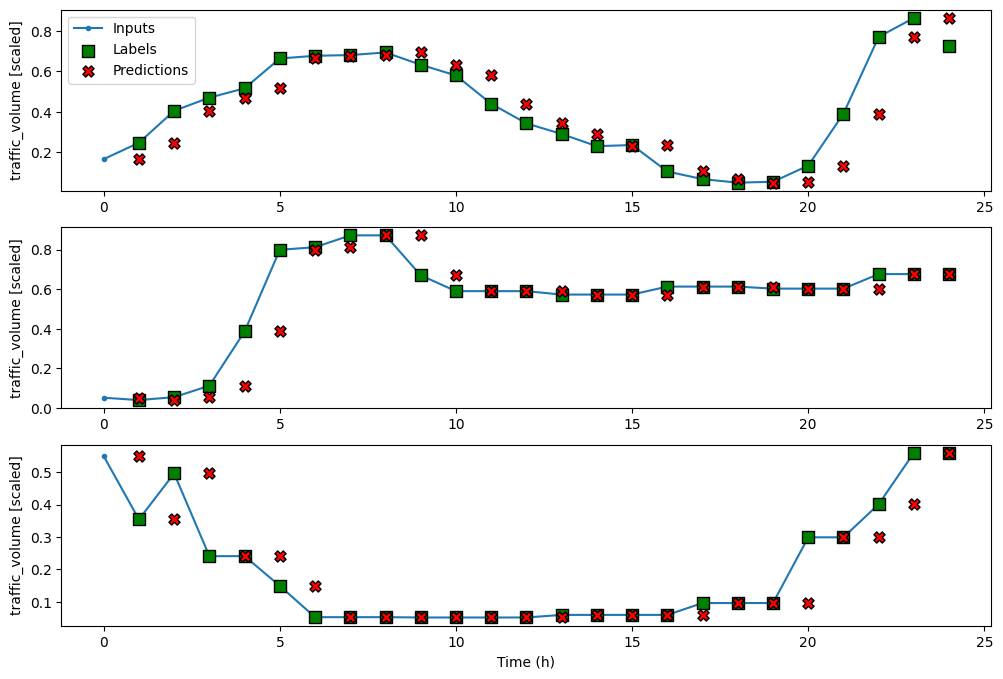

In [7]:
wide_window.plot(baseline_last)

We can optionally print the MAE of our baseline on the test set. 

This returns an MAE of 0.081. More complex models should perform better than the baseline, resulting in a smaller MAE.

In [8]:
print(performance['Baseline - Last'][1])

0.06674626469612122


### 13.2.2 Multi-step baseline models

In the previous section, we built a single-step baseline model that simply predicted the last known value. For multi-step models, we’ll predict more than one timestep into the future. In this case, we’ll forecast the traffic volume for the next 24 hours of data given an input of 24 hours.

Again, the first step is to generate the appropriate window of data. Because we wish to predict 24 timesteps into the future with an input of 24 hours, the input width is 24, the label width is 24, and the shift is also 24.

In [9]:
multi_window = DataWindow(input_width=24, label_width=24, shift=24, label_columns=['traffic_volume'])

With the data window generated, we can now focus on implementing the baseline models. In this situation, there are two reasonable baselines:
- Predict the last known value for the next 24 timesteps.
- Predict the last 24 timesteps for the next 24 timesteps.

With that in mind, let’s implement the first baseline, where we’ll simply repeat the last known value over the next 24 timesteps.

**PREDICTING THE LAST KNOWN VALUE**

To predict the last known value, we’ll define a MultiStepLastBaseline class that simply takes in the input and repeats the last value of the input sequence over 24 timesteps. This acts as the prediction of the model.

In [10]:
class MultiStepLastBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        if self.label_index is None:
            return tf.tile(inputs[:, -1:, :], [1, 24, 1])
        return tf.tile(inputs[:, -1:, self.label_index:], [1, 24, 1])

Next we’ll initialize the class and specify the target column. We’ll then repeat the same steps as in the previous section, compiling the model and evaluating it on the validation set and test set.

In [11]:
ms_baseline_last = MultiStepLastBaseline(label_index=column_indices['traffic_volume'])

ms_baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

ms_val_performance = {}
ms_performance = {}

ms_val_performance['Baseline - Last'] = ms_baseline_last.evaluate(multi_window.val)
ms_performance['Baseline - Last'] = ms_baseline_last.evaluate(multi_window.test, verbose=0)

300/300 [==============================] - 1s 2ms/step - loss: 0.1586 - mean_absolute_error: 0.3215


We can now visualize the predictions using the plot method of DataWindow.

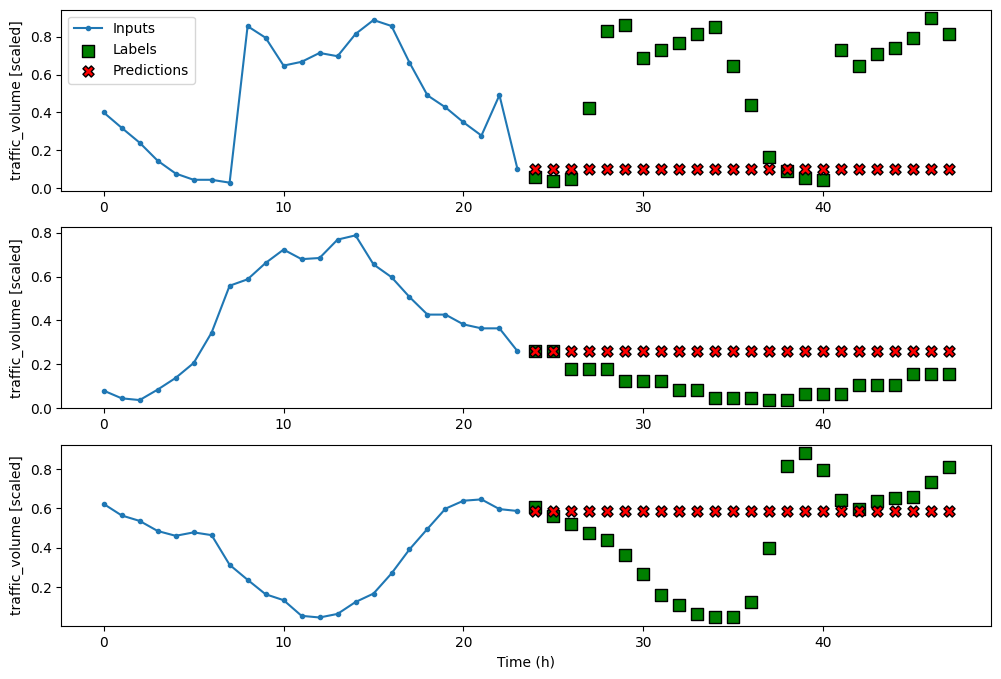

In [12]:
multi_window.plot(ms_baseline_last)

Again, we can optionally print the baseline’s MAE. From figure 13.10, we can expect it to be fairly high, since there is a large discrepancy between the labels and the predictions.

In [13]:
print(ms_performance['Baseline - Last'][1])

0.3197411298751831


This gives an MAE of 0.347. Now let’s see if we can build a better baseline by simply repeating the input sequence.

In [14]:
class RepeatBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        return inputs[:, :, self.label_index:]

Now we can initialize the baseline model and generate predictions. Note that the loss function and evaluation metric remain the same.

In [15]:
ms_baseline_repeat = RepeatBaseline(label_index=column_indices['traffic_volume'])

ms_baseline_repeat.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

ms_val_performance['Baseline - Repeat'] = ms_baseline_repeat.evaluate(multi_window.val)
ms_performance['Baseline - Repeat'] = ms_baseline_repeat.evaluate(multi_window.test, verbose=0)

300/300 [==============================] - 1s 3ms/step - loss: 0.1742 - mean_absolute_error: 0.3357


Next we can visualize the predictions. The result is shown in figure 13.11.

This baseline performs well. This is to be expected, since we identified daily seasonality in the previous chapter. This baseline is the equivalent to predicting the last known season.

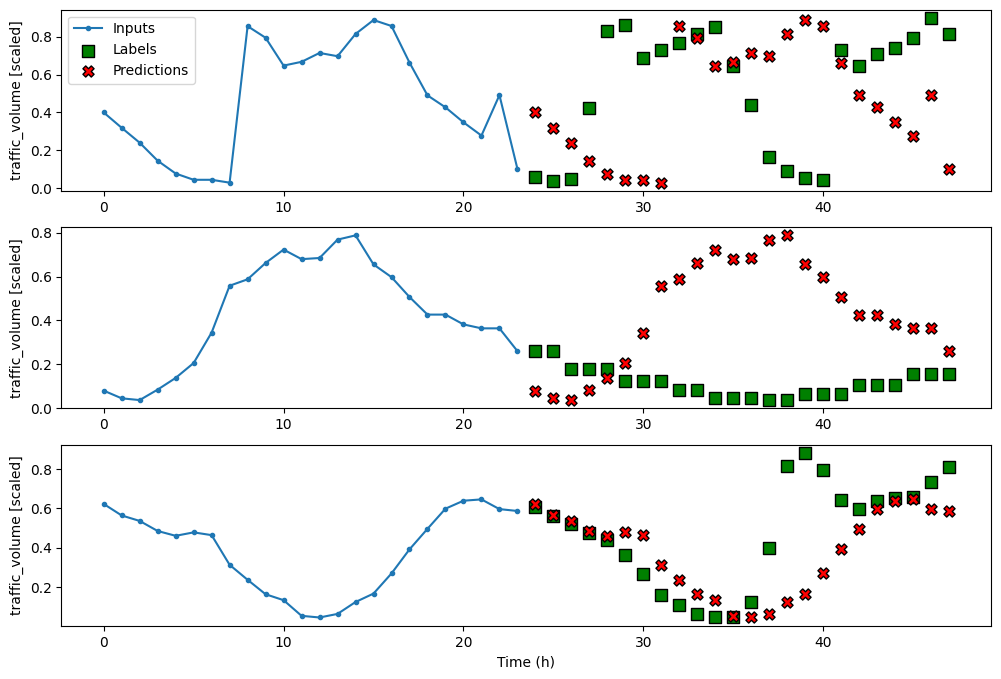

In [16]:
multi_window.plot(ms_baseline_repeat)

Again, we can print the MAE on the test set to verify that we indeed have a better baseline than simply predicting the last known value.

In [17]:
print(ms_performance['Baseline - Repeat'][1])

0.33657506108283997


This gives an MAE of 0.341, which is lower than the MAE obtained by predicting the last known value. We have therefore successfully built a better baseline.

### 13.2.3 Multi-output baseline model

The final type of model we’ll cover is the multi-output model. In this situation, we wish to predict the traffic volume and the temperature for the next timestep using a single input data point. Essentially, we’re applying the single-step model on both the traffic volume and temperature, making it a multi-output model.

Again, we’ll start off by defining the window of data, but here we’ll define two windows: One for training and the other for visualization. Since the model takes in one data point and outputs one prediction, we want to initialize a wide window of data to visualize many predictions over many timesteps.

In [18]:
mo_single_step_window = DataWindow(input_width=1, label_width=1, shift=1, label_columns=['temp','traffic_volume']) 
mo_wide_window = DataWindow(input_width=24, label_width=24, shift=1, label_columns=['temp','traffic_volume'])

Then we’ll use the Baseline class that we defined for the single-step model. Recall that this class can output the last known value for a list of targets.

In [19]:
print(column_indices['traffic_volume'])
print(column_indices['temp'])

2
0


In [20]:
mo_baseline_last = Baseline(label_index=[0, 2])

mo_baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

mo_val_performance = {}
mo_performance = {}

mo_val_performance['Baseline - Last'] = mo_baseline_last.evaluate(mo_wide_window.val)
mo_performance['Baseline - Last'] = mo_baseline_last.evaluate(mo_wide_window.test, verbose=0)

301/301 [==============================] - 1s 3ms/step - loss: 0.0053 - mean_absolute_error: 0.0346


Finally, we can visualize the predictions against the actual values. By default, our plot method will show the traffic volume on the y-axis, allowing us to quickly display one of our targets.

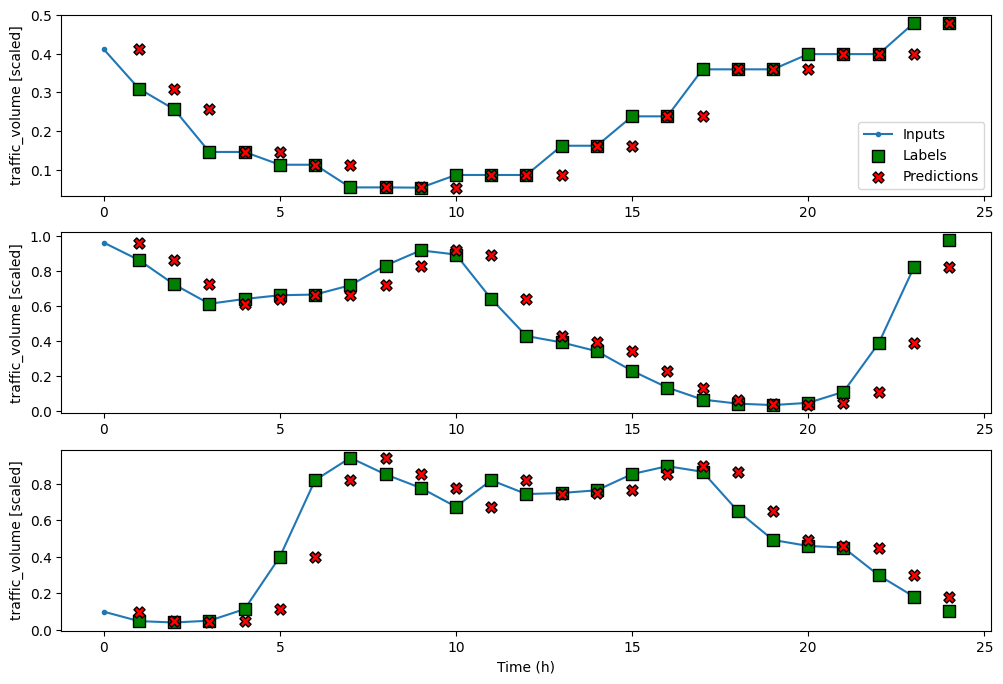

In [21]:
mo_wide_window.plot(mo_baseline_last)

Figure 13.12 does not show anything surprising, as we already saw these results when we built a single-step baseline model. The particularity of the multi-output model is that we also have predictions for the temperature. Of course, we can also visualize the predictions for the temperature by specifying the target in the plot method. 

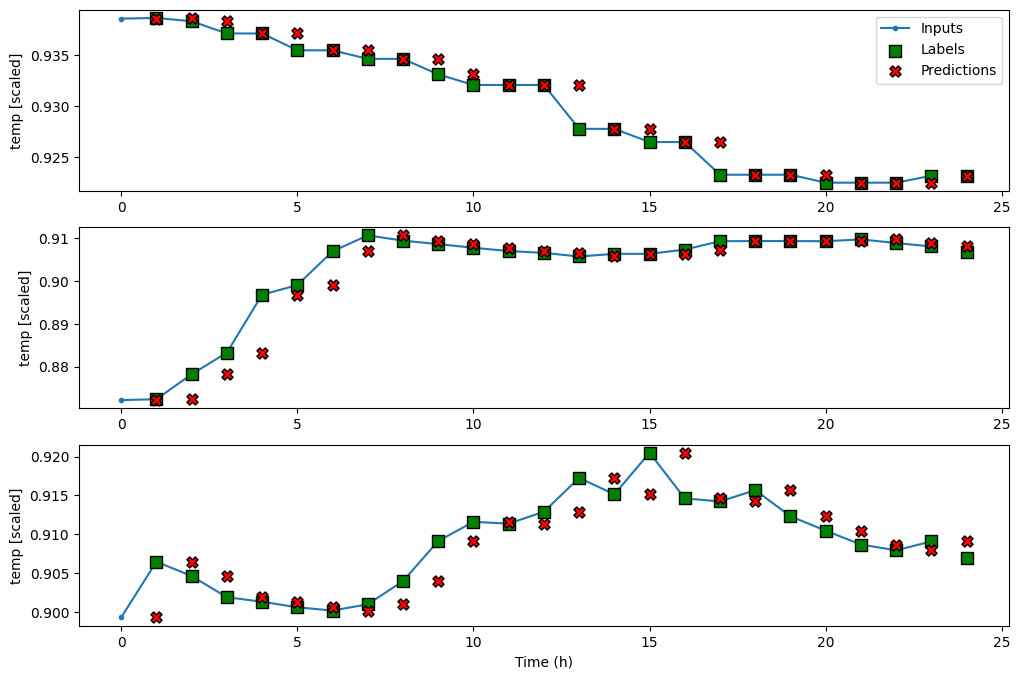

In [22]:
mo_wide_window.plot(model=mo_baseline_last, plot_col='temp')

Again, we can print the MAE of our baseline model.

In [23]:
print(mo_performance['Baseline - Last'])

[0.005185573361814022, 0.034467510879039764]


We obtain an MAE of 0.047 on the test set. In the next chapter, we’ll start building
more complex models, and they should result in a lower MAE, as they will be trained
to fit the data.

In [24]:
def compile_and_fit(model, window, patience=3, max_epochs=50):
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='min')
    
    model.compile(loss=MeanSquaredError(),
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError()])
    
    history = model.fit(window.train,
                       epochs=max_epochs,
                       validation_data=window.val,
                       callbacks=[early_stopping])
    
    return history


linear = Sequential([
    Dense(units=1)
])

history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/50
1055/1055 [==============================] - 4s 3ms/step - loss: 0.1849 - mean_absolute_error: 0.3072 - val_loss: 0.0282 - val_mean_absolute_error: 0.1376
Epoch 2/50
1055/1055 [==============================] - 4s 4ms/step - loss: 0.0192 - mean_absolute_error: 0.1081 - val_loss: 0.0116 - val_mean_absolute_error: 0.0811
Epoch 3/50
1055/1055 [==============================] - 3s 3ms/step - loss: 0.0119 - mean_absolute_error: 0.0788 - val_loss: 0.0090 - val_mean_absolute_error: 0.0682
Epoch 4/50
1055/1055 [==============================] - 3s 3ms/step - loss: 0.0109 - mean_absolute_error: 0.0726 - val_loss: 0.0084 - val_mean_absolute_error: 0.0642
Epoch 5/50
1055/1055 [==============================] - 3s 3ms/step - loss: 0.0106 - mean_absolute_error: 0.0705 - val_loss: 0.0081 - val_mean_absolute_error: 0.0623
Epoch 6/50
1055/1055 [==============================] - 3s 3ms/step - loss: 0.0104 - mean_absolute_error: 0.0696 - val_loss: 0.0080 - val_mean_absolute_error: 0.0615
Epoc

## 14.1 Implementing a linear model

A linear model is the simplest architecture we can implement in deep learning. In fact, we might argue that it is not deep learning at all, since the model has no hidden layer. Each input feature is simply given a weight, and they are combined to output a prediction for the target, just like in a traditional linear regression. Let’s consider a single-step model as an example. Recall that we have the following features in our dataset: temperature, cloud coverage, traffic volume, and day_sin and day_cos, which encode the time of day as numerical values. A linear model simply takes all the features, calculates a weight for each of them, and sums them to output a prediction for the next timestep. This process is illustrated in figure 14.1.

The model in figure 14.1 can be mathematically expressed as equation 14.1, where x1 is cloud coverage, x2 is temperature, x3 is traffic volume, x4 is day_sin, and x5 is day_cos.

$traffic volume_{t+1} = w_1 x_{1,t} + w_2 x_{2,t} + w_3 x_{3,t} + w_4 x_{4,t} + w_5 x_{5,t}$

We can easily recognize equation 14.1 as being a simple multivariate linear regression. During training, the model tries multiple values for w1 to w5 in order to minimize the mean squared error (MSE) between the prediction and actual value of the traffic volume at the next timestep.

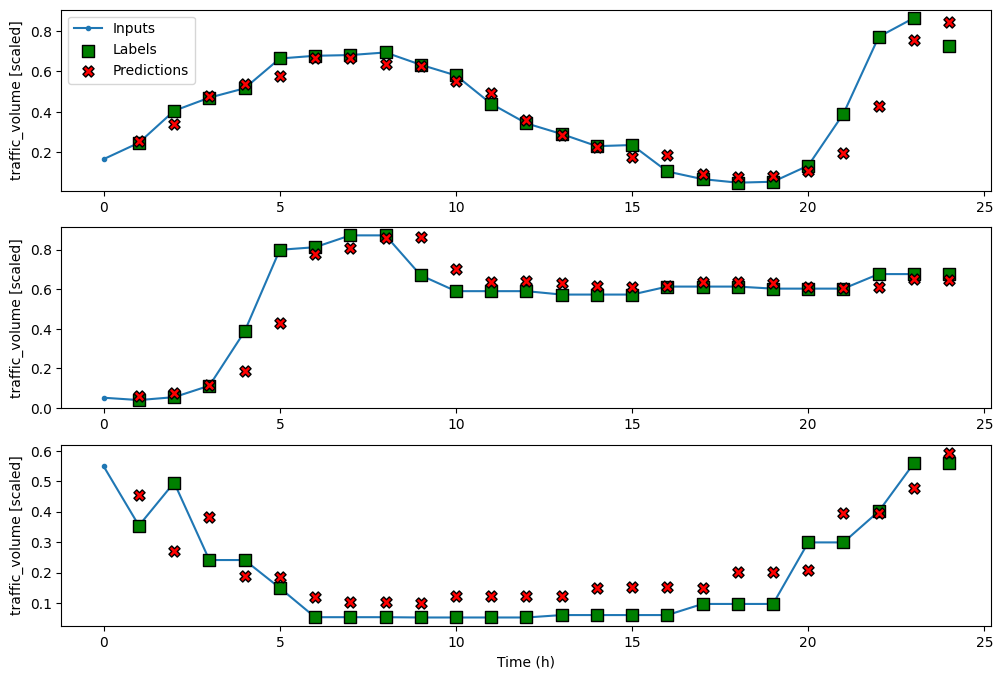

In [25]:
wide_window.plot(linear)

In [26]:
ms_linear = Sequential([
    Dense(1, kernel_initializer=tf.initializers.zeros)
])

history = compile_and_fit(ms_linear, multi_window)

ms_val_performance['Linear'] = ms_linear.evaluate(multi_window.val)
ms_performance['Linear'] = ms_linear.evaluate(multi_window.test, verbose=0)

Epoch 1/50
1053/1053 [==============================] - 4s 4ms/step - loss: 0.0754 - mean_absolute_error: 0.2335 - val_loss: 0.0597 - val_mean_absolute_error: 0.2051
Epoch 2/50
1053/1053 [==============================] - 4s 4ms/step - loss: 0.0638 - mean_absolute_error: 0.2122 - val_loss: 0.0591 - val_mean_absolute_error: 0.2035
Epoch 3/50
1053/1053 [==============================] - 3s 3ms/step - loss: 0.0637 - mean_absolute_error: 0.2119 - val_loss: 0.0591 - val_mean_absolute_error: 0.2033
Epoch 4/50
1053/1053 [==============================] - 3s 3ms/step - loss: 0.0637 - mean_absolute_error: 0.2118 - val_loss: 0.0591 - val_mean_absolute_error: 0.2035
Epoch 5/50
1053/1053 [==============================] - 3s 3ms/step - loss: 0.0638 - mean_absolute_error: 0.2118 - val_loss: 0.0591 - val_mean_absolute_error: 0.2032
Epoch 6/50
1053/1053 [==============================] - 4s 4ms/step - loss: 0.0638 - mean_absolute_error: 0.2118 - val_loss: 0.0591 - val_mean_absolute_error: 0.2033
Epoc

## 14.2 Implementing a deep neural network

With our three types of linear models implemented, it is time to move on to deep neural networks. It has been empirically shown that adding hidden layers in neural networks helps achieve better results. Furthermore, we’ll introduce a nonlinear activation
function to capture nonlinear relationships in the data.

Linear models have no hidden layers; the model had an input layer and an output layer. In a deep neural network (DNN), we’ll add more layers between the input and output layers, called hidden layers. This difference in architecture is highlighted in figure
14.5.

The idea behind adding layers to the network is that it gives the model more opportunities to learn, which usually results in the model generalizing better on unseen data, thus improving its performance. Of course, with added layers, the model necessarily trains for a longer time and is thus supposed to learn better.

Each circle in a hidden layer represents a neuron, and each neuron has an activation function. The number of neurons is equal to the number of units that is passed as an argument in the Dense layer in Keras. Usually we set the number of units, or neurons, as a power of 2, as it is more computationally efficient—calculations in the CPU and GPU happen in batch sizes that are also powers of 2.

Before implementing a DNN, we need to address the activation function in each neuron of the hidden layers. The activation function defines the output of each neuron based on the input. Therefore, if we wish to model nonlinear relationships, we need to use a nonlinear activation function.

In our case, we’ll use the Rectified Linear Unit (ReLU) activation function. This nonlinear activation function basically returns either the positive part of its input or 0, as defined by equation 14.2.

$f(x) = x^x = max (0, x)$ 

This activation function comes with many advantages, such as better gradient propagation, more efficient computation, and scale-invariance. For all those reasons, it is now the most widely used activation function in deep learning, and we’ll use it whenever
we have a Dense layer that is a hidden layer.

We are now ready to implement a deep neural network in Keras.

### 14.2.1 Implementing a deep neural network as a single-step model

We are now back to the single-step model, but this time we’ll implement a deep neural network. The DNN takes in the features at the current timestep to output the prediction for traffic volume at the next timestep.

The model still makes use of the Sequential model, as we’ll stack Dense layers in order to build a deep neural network. In this case, we’ll use two hidden layers with 64 neurons each. As mentioned before, we’ll specify the activation function to be ReLU. 

The last layer is the output layer, which in this case only returns one value representing the prediction for traffic volume.

In [27]:

dense = Sequential([
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/50
1055/1055 [==============================] - 5s 4ms/step - loss: 0.0096 - mean_absolute_error: 0.0653 - val_loss: 0.0046 - val_mean_absolute_error: 0.0528
Epoch 2/50
1055/1055 [==============================] - 4s 4ms/step - loss: 0.0061 - mean_absolute_error: 0.0529 - val_loss: 0.0041 - val_mean_absolute_error: 0.0473
Epoch 3/50
1055/1055 [==============================] - 5s 4ms/step - loss: 0.0056 - mean_absolute_error: 0.0497 - val_loss: 0.0036 - val_mean_absolute_error: 0.0434
Epoch 4/50
1055/1055 [==============================] - 4s 4ms/step - loss: 0.0054 - mean_absolute_error: 0.0479 - val_loss: 0.0043 - val_mean_absolute_error: 0.0501
Epoch 5/50
1055/1055 [==============================] - 4s 4ms/step - loss: 0.0052 - mean_absolute_error: 0.0461 - val_loss: 0.0031 - val_mean_absolute_error: 0.0395
Epoch 6/50
1055/1055 [==============================] - 5s 4ms/step - loss: 0.0052 - mean_absolute_error: 0.0461 - val_loss: 0.0036 - val_mean_absolute_error: 0.0426
Epoc

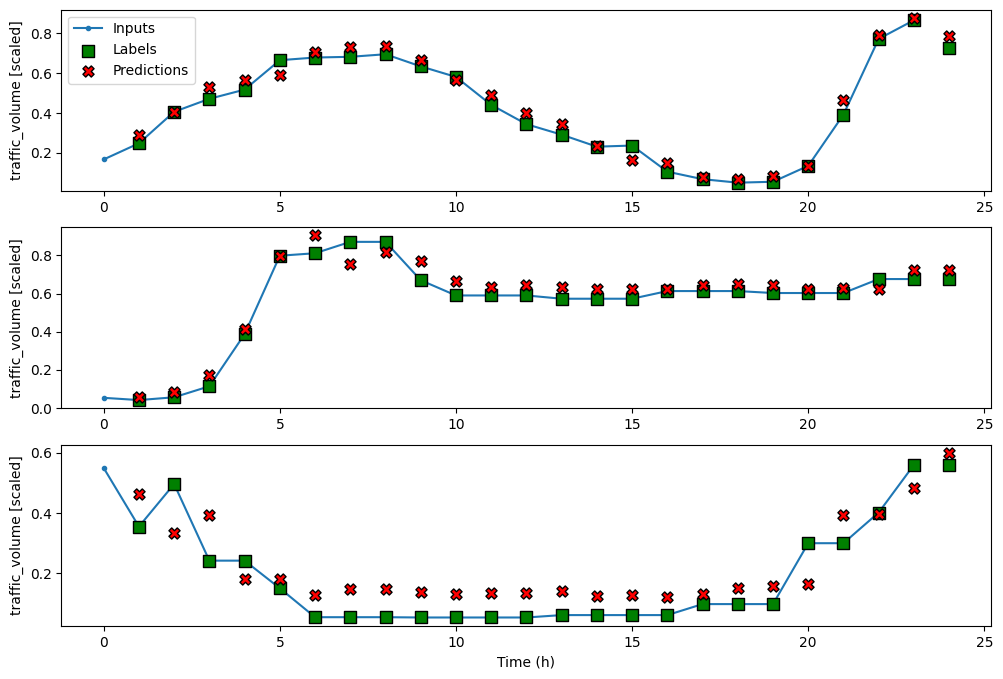

In [28]:
wide_window.plot(dense)                                                                                                                                                                                                                                                                                                                              

Let’s compare the MAE of the DNN with the linear model and the baseline that we built in chapter 13. The result is shown in figure 14.7.

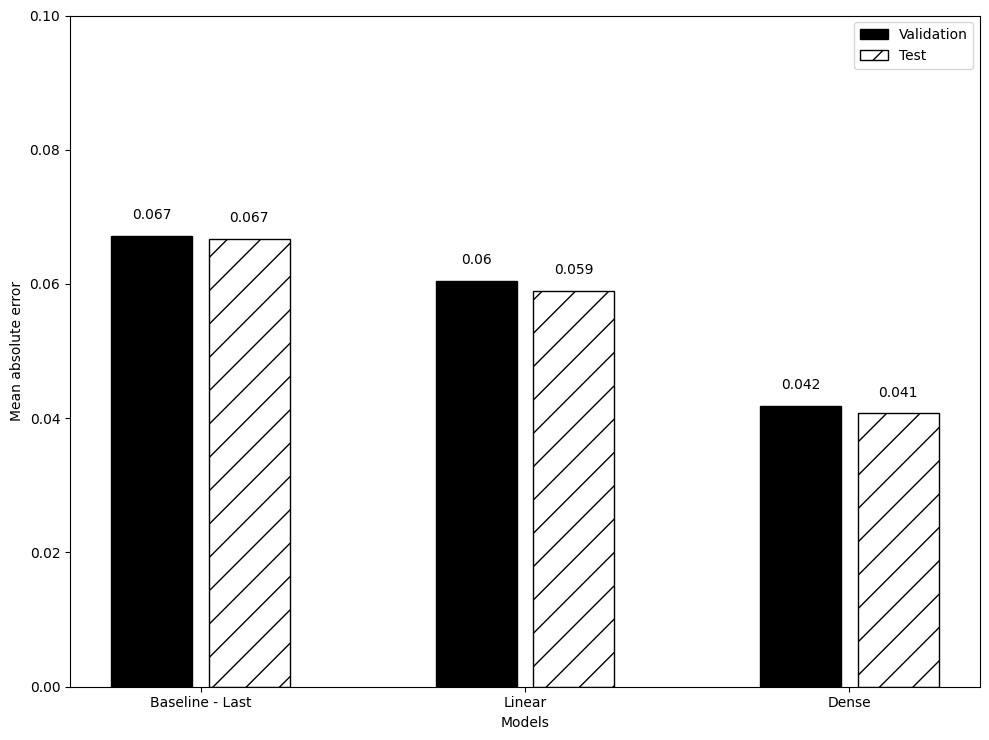

In [29]:
mae_val = [v[1] for v in val_performance.values()]
mae_test = [v[1] for v in performance.values()]

x = np.arange(len(performance))

fig, ax = plt.subplots()
ax.bar(x - 0.15, mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.1)
plt.xticks(ticks=x, labels=performance.keys())
plt.legend(loc='best')
plt.tight_layout()

In figure 14.7 the MAE is highest for the baseline. It decreases with the linear model and decreases again with the deep neural network. Thus, both models outperformed the baseline, with the deep neural network having the best performance.

### 14.2.2 Implementing a deep neural network as a multi-step model

Now let’s implement a deep neural network as a multi-step model. In this case, we want to predict the next 24 hours of traffic volume based on the last 24 hours of recorded data.

Again we’ll use two hidden layers with 64 neurons each, and we’ll use the ReLU activation function. Since we have a data window with 24 hours of input, the model will also output 24 hours of predictions; the output layer simply has one neuron because we are predicting traffic volume only.

In [30]:
ms_dense = Sequential([
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(ms_dense, multi_window)

ms_val_performance['Dense'] = ms_dense.evaluate(multi_window.val)
ms_performance['Dense'] = ms_dense.evaluate(multi_window.test, verbose=0)

Epoch 1/50
1053/1053 [==============================] - 7s 6ms/step - loss: 0.0631 - mean_absolute_error: 0.2059 - val_loss: 0.0522 - val_mean_absolute_error: 0.1837
Epoch 2/50
1053/1053 [==============================] - 5s 5ms/step - loss: 0.0580 - mean_absolute_error: 0.1972 - val_loss: 0.0506 - val_mean_absolute_error: 0.1818
Epoch 3/50
1053/1053 [==============================] - 5s 5ms/step - loss: 0.0573 - mean_absolute_error: 0.1954 - val_loss: 0.0499 - val_mean_absolute_error: 0.1782
Epoch 4/50
1053/1053 [==============================] - 5s 5ms/step - loss: 0.0570 - mean_absolute_error: 0.1943 - val_loss: 0.0504 - val_mean_absolute_error: 0.1817
Epoch 5/50
1053/1053 [==============================] - 5s 5ms/step - loss: 0.0567 - mean_absolute_error: 0.1936 - val_loss: 0.0497 - val_mean_absolute_error: 0.1798
Epoch 6/50
1053/1053 [==============================] - 5s 5ms/step - loss: 0.0565 - mean_absolute_error: 0.1931 - val_loss: 0.0501 - val_mean_absolute_error: 0.1814
Epoc

Just like that, we have built a multi-step deep neural network model. Let’s see which model performed best for the multi-step task. The result is shown in figure 14.8.

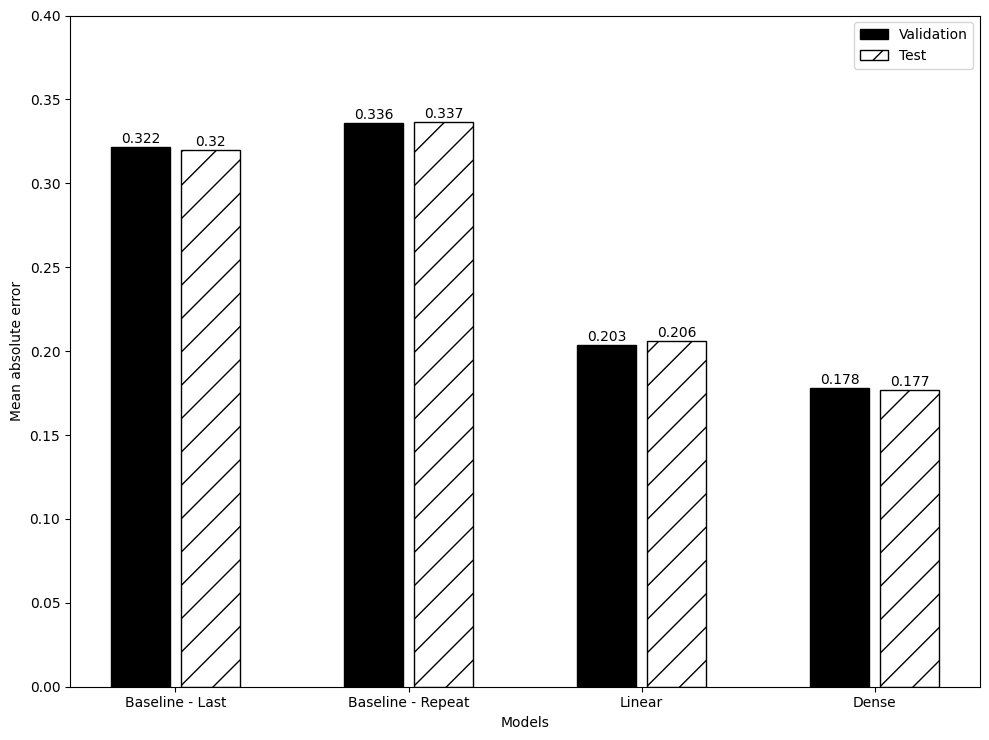

In [31]:
ms_mae_val = [v[1] for v in ms_val_performance.values()]
ms_mae_test = [v[1] for v in ms_performance.values()]

x = np.arange(len(ms_performance))

fig, ax = plt.subplots()
ax.bar(x - 0.15, ms_mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, ms_mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(ms_mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(ms_mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.4)
plt.xticks(ticks=x, labels=ms_performance.keys())
plt.legend(loc='best')
plt.tight_layout()

In figure 14.8 you’ll see that the linear model and deep neural network both outperform the two baselines that we built for the multi-step task in chapter 13. Again, the deep neural network has the lowest MAE of all, meaning that it is the most performant model for now.

### 14.2.3 Implementing a deep neural network as a multi-output model

Finally, we’ll implement a deep neural network as a multi-output model. In this case, we’ll use the features at the present timestep to forecast both the traffic volume and temperature at the next timestep.

As for the previous DNNs that we implemented, we’ll use two hidden layers of 64 neurons each. This time, because we are forecasting two targets, our output layer has two neurons or units.

In [32]:
mo_dense = Sequential([
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=2)
])

history = compile_and_fit(mo_dense, mo_single_step_window)

mo_val_performance['Dense'] = mo_dense.evaluate(mo_single_step_window.val)
mo_performance['Dense'] = mo_dense.evaluate(mo_single_step_window.test, verbose=0)

Epoch 1/50
1055/1055 [==============================] - 5s 4ms/step - loss: 0.0076 - mean_absolute_error: 0.0472 - val_loss: 0.0026 - val_mean_absolute_error: 0.0329
Epoch 2/50
1055/1055 [==============================] - 4s 4ms/step - loss: 0.0034 - mean_absolute_error: 0.0326 - val_loss: 0.0018 - val_mean_absolute_error: 0.0258
Epoch 3/50
1055/1055 [==============================] - 5s 4ms/step - loss: 0.0029 - mean_absolute_error: 0.0289 - val_loss: 0.0019 - val_mean_absolute_error: 0.0264
Epoch 4/50
1055/1055 [==============================] - 4s 3ms/step - loss: 0.0028 - mean_absolute_error: 0.0278 - val_loss: 0.0022 - val_mean_absolute_error: 0.0288
Epoch 5/50
1055/1055 [==============================] - 4s 4ms/step - loss: 0.0027 - mean_absolute_error: 0.0273 - val_loss: 0.0016 - val_mean_absolute_error: 0.0234
Epoch 6/50
1055/1055 [==============================] - 4s 4ms/step - loss: 0.0027 - mean_absolute_error: 0.0266 - val_loss: 0.0017 - val_mean_absolute_error: 0.0237
Epoc

Let’s see which model performed best at the multi-output task. Note that the reported MAE is averaged for both targets.

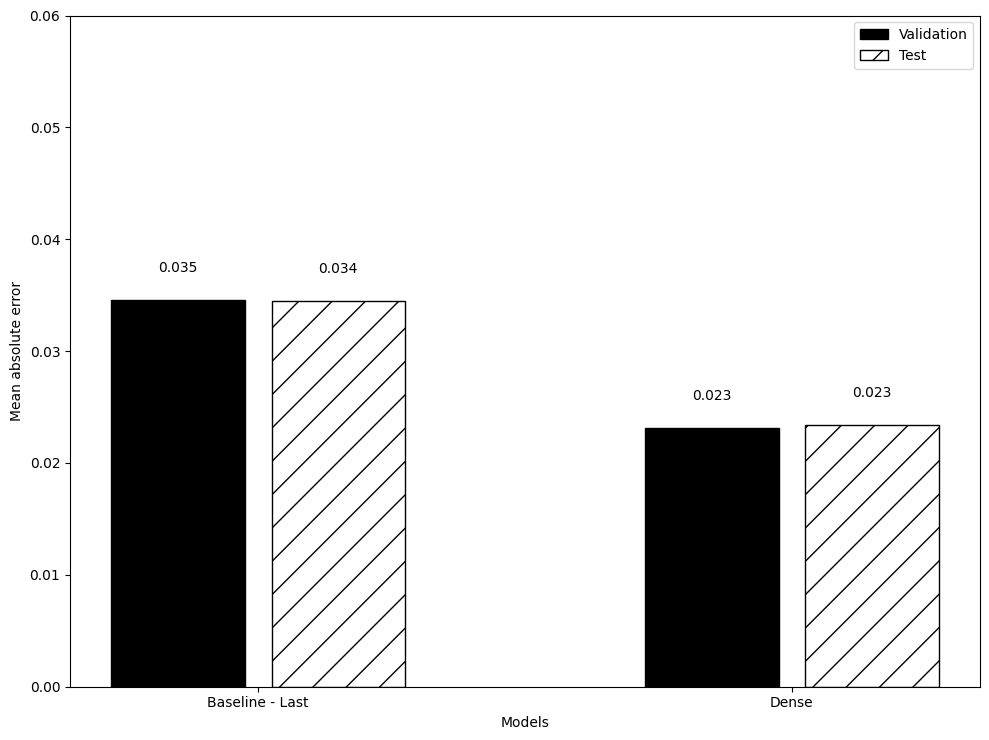

In [33]:
mo_mae_val = [v[1] for v in mo_val_performance.values()]
mo_mae_test = [v[1] for v in mo_performance.values()]

x = np.arange(len(mo_performance))

fig, ax = plt.subplots()
ax.bar(x - 0.15, mo_mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mo_mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mo_mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(mo_mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.06)
plt.xticks(ticks=x, labels=mo_performance.keys())
plt.legend(loc='best')
plt.tight_layout()

As you can see in figure 14.9, our models outperform the baseline, with the deep learning model being the most performant.